In [1]:
import torch
from torch import Tensor
import numpy as np
from torch import nn
import dlc_bci as bci
from torch.autograd import Variable
from torch import optim
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import model_selection

In [3]:
train_input, train_target = bci.load(root = './data_bci')
X = train_input.numpy()
y = train_target.numpy()
kfolds = model_selection.KFold(n_splits=3, random_state=1234, shuffle=True)
# print(str(type(train_input)), train_input.size()) 
# print(str(type(train_target)), train_target.size())
# test_input , test_target = bci.load(root = './data_bci', train = False)
# print(str(type(test_input)), test_input.size()) 
# print(str(type(test_target)), test_target.size())

### 0. Data loading and preprocessing

#### Data loading

In [7]:
train_input, train_target = bci.load(root = './data_bci')
print(str(type(train_input)), train_input.size()) 
print(str(type(train_target)), train_target.size())
test_input , test_target = bci.load(root = './data_bci', train = False)
print(str(type(test_input)), test_input.size()) 
print(str(type(test_target)), test_target.size())

<class 'torch.FloatTensor'> torch.Size([316, 28, 50])
<class 'torch.LongTensor'> torch.Size([316])
<class 'torch.FloatTensor'> torch.Size([100, 28, 50])
<class 'torch.LongTensor'> torch.Size([100])


#### Data normalization

In [8]:
# put this inside the train to avoid data snooping

mu, std = train_input.mean(0), train_input.std(0)
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std)
print("Normalization is done!")

Normalization is done!


#### Utility functions

In [11]:
def train_model(model, train_input, train_target, test_input, test_target, kfolds, nb_epochs, lambdda =0.01):
    print(lambdda)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.01)
    costs = []
    costs_val=[]
    
    acc_train_epoch = []
    loss_train_epoch = []
    acc_val_epoch = []
    loss_val_epoch = []
    
    for e in range(0, nb_epochs):
        acc_train = []
        acc_val = []
        loss_train = []
        loss_val = []
         
        for train_index, val_index in kfolds.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            X_train = Variable(torch.from_numpy(X_train))
            X_val = Variable(torch.from_numpy(X_val))
            y_train = Variable(torch.from_numpy(y_train))
            y_val = Variable(torch.from_numpy(y_val))    
            
            model.train(True)
            for b in range(0, X_train.size(0), mini_batch_size):
                output = model(X_train.narrow(0, b, mini_batch_size))
                loss = criterion(output, y_train.narrow(0, b, mini_batch_size))
                for p in model.parameters():
                    loss += lambdda*p.pow(2).sum()
                model.zero_grad()
                loss.backward()
                optimizer.step()
                
            model.train(False)
            output_train = model(X_train)
            output_val = model(X_val)
            
            acc_val.append(1-compute_nb_errors(model, X_val, y_val, mini_batch_size=20)/X_val.size(0))
            acc_train.append(1-compute_nb_errors(model, X_train, y_train, mini_batch_size=20)/X_train.size(0))
            loss_train.append(criterion(output_train, y_train).data[0])
            loss_val.append(criterion(output_val, y_val).data[0])
            
        acc_train_epoch.append(acc_train.mean())
        acc_val_epoch.append(acc_val.mean())
        
        loss_train_epoch.append(loss_train.mean())
        loss_val_epoch.append(loss_val.mean())
        

    return loss_train_epoch, loss_val_epoch, acc_train_epoch, acc_val_epoch


def compute_nb_errors(model, data_input, data_target, mini_batch_size):
    nb_data_errors = 0

    for b in range(0, data_input.size(0), mini_batch_size):
        output = model(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(output.data, 1)
        for k in range(0, mini_batch_size):
            if data_target.data[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors

### 1. Linear model

### 2. Fully connected model

#### Create network

In [12]:
class FC_net(nn.Module):
    def __init__(self, layers):
        super(FC_net, self).__init__() 
        self.additional_hidden = nn.ModuleList()
        for l in range(len(layers)-1):
            self.additional_hidden.append(nn.Linear(layers[l], layers[l+1]))

    def forward(self, x):
        x=x.view(x.shape[0], -1)
        for l in range(len(self.additional_hidden)-1):
            x = F.relu(self.additional_hidden[l](x))
        x = self.additional_hidden[-1](x)
        return x

#### Train network

In [13]:
#check model parameters
layers = [train_input.view(train_input.shape[0], -1).shape[1], 5, 5, 2]
model_fc = FC_net(layers)
for k in model_fc.parameters():
    print(k.size())
    
mini_batch_size = 42
nb_epochs = 1000
costs, costs_val, acc, acc_val = train_model(model_fc, train_input, train_target, test_input, kfolds, test_target, nb_epochs, lambdda=0.02)


torch.Size([5, 1400])
torch.Size([5])
torch.Size([5, 5])
torch.Size([5])
torch.Size([2, 5])
torch.Size([2])
0.02


/Users/lia/miniconda3/lib/python3.6/site-packages/torch/functional.py:25: RuntimeWarning: invalid value encountered in floor_divide
  num_splits = (dim_size + split_size - 1) // split_size


TypeError: only integer scalar arrays can be converted to a scalar index

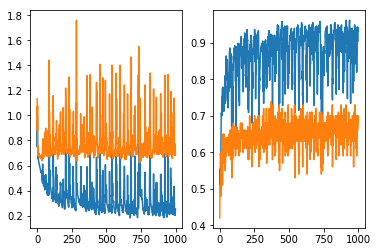

In [109]:
#plot learning curves
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot (range(nb_epochs), costs)
ax1.plot (range(nb_epochs), costs_val)
ax2.plot (range(nb_epochs), acc)
ax2.plot (range(nb_epochs), acc_val)

#### Assess network

In [10]:
print('train_error {:.02f}%'.format(
            compute_nb_errors(model_fc, train_input, train_target, mini_batch_size = 79) / train_input.size(0) * 100))
print('test_error {:.02f}%'.format(
            compute_nb_errors(model_fc, test_input, test_target, mini_batch_size = 20) / test_input.size(0) * 100))

# print("train data error = {}/316 %".format(compute_nb_errors(model, train_input, train_target))
# compute_nb_errors(model, test_input, test_target)

train_error 7.91%
test_error 37.00%


In [11]:
#train model few times and take average, because of different initialization
#figure out the case when is 50% error for both

### 3. Convolutional neural network

In [12]:
class Conv_net(nn.Module):
    def __init__(self, layers, layers_conv, kernel_size, pooling_kernel_size, p):
        super(Conv_net, self).__init__()
        self.pooling_kernel_size = pooling_kernel_size
        self.additional_conv_hidden = nn.ModuleList()
        self.additional_fc_hidden = nn.ModuleList()
        self.droput_layers = nn.ModuleList()
        self.batch_normalization = nn.ModuleList()
        
        for l in range(len(layers_conv)-1):
            self.additional_conv_hidden.append(nn.Conv1d(layers_conv[l], layers_conv[l+1], kernel_size=kernel_size[l]))
            self.droput_layers.append(torch.nn.Dropout(p=p[l]))
            self.batch_normalization.append(torch.nn.BatchNorm1d(layers_conv[l+1]))
        size = train_input.shape[2]

        for i in range(len(kernel_size)):
            size-=(kernel_size[i]-1)

            size//=pooling_kernel_size[i]

        self.additional_fc_hidden.append(nn.Linear(size*layers_conv[-1], layers[0]))
        self.droput_layers.append(torch.nn.Dropout(p=p[l+1]))
        self.batch_normalization.append(torch.nn.BatchNorm1d(layers[0]))
        self.flat_size = size*layers_conv[-1]
        
        start_p = l+2

        for l in range(len(layers)-1):
            self.additional_fc_hidden.append(nn.Linear(layers[l], layers[l+1]))
            if l != len(layers)-2:
                self.droput_layers.append(torch.nn.Dropout(p=p[l+start_p]))
                self.batch_normalization.append(torch.nn.BatchNorm1d(layers[l+1]))

    def forward(self, x):
        for l in range(len(self.additional_conv_hidden)):
            x = self.droput_layers[l](self.batch_normalization[l](F.relu(F.max_pool1d(self.additional_conv_hidden[l](x), \
                                                          kernel_size=self.pooling_kernel_size[l]))))
        x=x.view(-1, self.flat_size)
        for l in range(len(self.additional_fc_hidden)-1):
            index = len(self.additional_conv_hidden)+l
            x = self.droput_layers[index](self.batch_normalization[index](F.relu(self.additional_fc_hidden[l](x))))
        x = self.additional_fc_hidden[-1](x)
        return x

#### Train network

In [13]:
p_list = [0.2, 0.2, 0]
layers = [5, 2]
layers_conv = [28, 4, 4]
kernel_size = [6, 6]
pooling_kernel_size = [3, 2]
model_conv = Conv_net(layers, layers_conv, kernel_size, pooling_kernel_size, p_list)
for k in model_conv.parameters():
    print(k.size())
    
mini_batch_size = 79
nb_epochs = 1000
costs, costs_val, acc, acc_val = train_model(model_conv, train_input, train_target, test_input, \
                                             test_target, nb_epochs, lambdda=0.0375)
                                             

3
torch.Size([4, 28, 6])
torch.Size([4])
torch.Size([4, 4, 6])
torch.Size([4])
torch.Size([5, 20])
torch.Size([5])
torch.Size([2, 5])
torch.Size([2])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([5])
torch.Size([5])


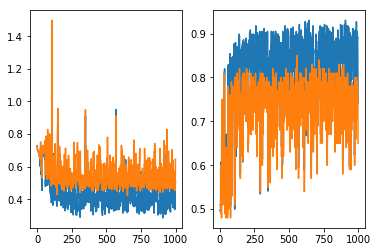

In [14]:
#plot learning curves
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot (range(nb_epochs), costs)
ax1.plot (range(nb_epochs), costs_val)
ax2.plot (range(nb_epochs), acc)
ax2.plot (range(nb_epochs), acc_val)

In [15]:
print('train_error {:.02f}%'.format(
            compute_nb_errors(model_conv, train_input, train_target, mini_batch_size = 79) / train_input.size(0) * 100))
print('test_error {:.02f}%'.format(
            compute_nb_errors(model_conv, test_input, test_target, mini_batch_size = 20) / test_input.size(0) * 100))

train_error 25.95%
test_error 35.00%
